In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from scandataset import SCANDataset
from transformer import Transformer
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from hyperparam_config.hyperparam_exp1 import *

In [2]:
MAX_LEN = 50

src_vocab = [
    '<PAD>',
    '<BOS>',
    '<EOS>',
    'walk',
    'look',
    'run',
    'jump',
    'turn',
    'left',
    'right',
    'and',
    'after',
    'opposite',
    'twice',
    'thrice',
    'around',
]

tgt_vocab = [
    '<PAD>',
    '<BOS>',
    '<EOS>',
    'I_WALK',
    'I_RUN',
    'I_JUMP',
    'I_LOOK',
    'I_TURN_RIGHT',
    'I_TURN_LEFT'
]


def list_to_dict(lst):
    return {k: v for v, k in enumerate(lst)}


# mapping the vocabulary to indeces
src_vocab = list_to_dict(src_vocab)
tgt_vocab = list_to_dict(tgt_vocab)

SPECIAL_TOKENS = [tgt_vocab['<PAD>'], tgt_vocab['<BOS>'], tgt_vocab['<EOS>']]


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
paths = []

for exponent in range(0, 7):
    pow2 = 2**exponent
    paths.append((
        os.path.join('data', 'simple_split', 'size_variations', f'tasks_train_simple_p{pow2}.txt'),
        os.path.join('data', 'simple_split', 'size_variations', f'tasks_test_simple_p{pow2}.txt')
    ))

paths.append((
    os.path.join('data', 'simple_split', f'tasks_train_simple.txt'),
    os.path.join('data', 'simple_split', f'tasks_test_simple.txt')
))

In [5]:
def train_loss_over_epochs(path, scheduled_sampling=True):

    dataset = SCANDataset(
        file_path=path,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        max_len=MAX_LEN,
    )

    # split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    model = Transformer(
        src_vocab_size=len(src_vocab),
        tgt_vocab_size=len(tgt_vocab),
        src_pad_idx=src_vocab['<PAD>'],
        tgt_pad_idx=tgt_vocab['<PAD>'],
        emb_dim=EMB_DIM,
        num_layers=N_LAYERS,
        num_heads=N_HEADS,
        forward_dim=FORWARD_DIM,
        dropout=DROPOUT,
        max_len=MAX_LEN + 1,
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<PAD>'])

    nr_epochs = 25
    train_losses = []
    val_losses = []

    for _ in tqdm.tqdm(range(nr_epochs)):
        # training
        model.train()
        total_train_loss = 0
        for batch in train_dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            if scheduled_sampling == True:
                teacher_force_prob = np.random.randint(0, 100)
                if teacher_force_prob > 50:
                    # shift target one position to the left for teacher-forcing
                    pred = model.forward(src, tgt[:, :-1])
                    # handling shifted target input shifting one position to the right
                    transformed_tgt = tgt[:, 1:].reshape(-1)
                else:
                    pred = model.predict_logits(src, tgt, tgt_vocab['<BOS>'])
                    transformed_tgt = tgt[:, 1:].contiguous().view(-1)
            else:
                pred = model.forward(src, tgt[:, :-1])
                transformed_tgt = tgt[:, 1:].reshape(-1)

            transformed_pred = pred.contiguous().view(-1, pred.shape[-1])
            loss = criterion(transformed_pred, transformed_tgt)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

            total_train_loss += loss.item()

        train_losses.append(total_train_loss/len(train_dataloader))

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                src = batch['src'].to(device)
                tgt = batch['tgt'].to(device)

                # check if scheduled sampling was used
                if scheduled_sampling == True:
                    pred = model.predict_logits(src, tgt, tgt_vocab['<BOS>'])
                    transformed_tgt = tgt[:, 1:].contiguous().view(-1)
                else:
                    pred = model.forward(src, tgt[:, :-1])
                    transformed_tgt = tgt[:, 1:].contiguous().view(-1)

                transformed_pred = pred.contiguous().view(-1, pred.shape[-1])
                val_loss = criterion(transformed_pred, transformed_tgt)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)


    X = list(range(1, nr_epochs + 1))

    plt.figure(figsize=(8, 6))  # Set figure size
    plt.plot(X, train_losses, marker='o', label='Training Loss')  # Plot losses
    plt.plot(X, val_losses, marker='o', label='Validation Loss', linestyle='--')
    plt.title(f"Learning curve for the data in {os.path.basename(path)} ({'Scheduled Sampling' if scheduled_sampling else 'Teacher-forcing'})")  # Set the title
    plt.xticks(X)
    plt.xlabel('Epoch')  # Label for the x-axis
    plt.ylabel('Loss')  # Label for the y-axis
    plt.grid(True)  # Add gridlines for better readability
    plt.legend()  # Add legend
    plt.savefig(f"plots//learning curve {os.path.basename(path)} ({'Scheduled Sampling' if scheduled_sampling else 'Teacher-forcing'}).png")
    plt.show()  # Display the plot

In [6]:
def train_loop(model, optimizer, criterion, dataloader, epochs, scheduled_sampling=True):
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        total_loss = 0
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            if scheduled_sampling == True:
                teacher_force_prob = np.random.randint(0, 100)
                if teacher_force_prob > 50:
                    # shift target one position to the left for teacher-forcing
                    pred = model.forward(src, tgt[:, :-1])
                    # handling shifted target input shifting one position to the right
                    transformed_tgt = tgt[:, 1:].reshape(-1)
                else:
                    pred = model.predict_logits(src, tgt, tgt_vocab['<BOS>'])
                    transformed_tgt = tgt[:, 1:].contiguous().view(-1)
            else:
                pred = model.forward(src, tgt[:, :-1])
                transformed_tgt = tgt[:, 1:].reshape(-1)


            transformed_pred = pred.contiguous().view(-1, pred.shape[-1])
            loss = criterion(transformed_pred, transformed_tgt)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

            total_loss += loss

        print(f"Epoch {epoch + 1}, Loss: {total_loss/len(dataloader):.4f}")


def should_ignore(t):
    return t == tgt_vocab['<BOS>'] or t == tgt_vocab['<EOS>'] or t == tgt_vocab['<PAD>']

def eval_loop(model, dataloader, scheduled_sampling=True):
    model.eval()
    total_tokens = 0
    correct_tokens = 0
    total_seq = 0
    correct_seq = 0
    with torch.no_grad():
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            if scheduled_sampling == True:
                pred = model.foward(src, tgt, tgt_vocab['<BOS>'])
                transformed_tgt = tgt[:, 1:].contiguous().view(-1)
            else:
                pred = model.preidct(src, tgt[:, :-1], tgt_vocab['<BOS>'])
                transformed_tgt = tgt[:, 1:].contiguous().view(-1)

            transformed_pred = pred.contiguous().view(-1, pred.shape[-1])

            transformed_pred = torch.argmax(transformed_pred, -1)
            # calculate token-level accuracy
            for pred_token, target_token in zip(transformed_pred, transformed_tgt):
                if should_ignore(target_token):
                    continue
                total_tokens += 1
                if pred_token == target_token:
                    correct_tokens += 1
                if pred_token == tgt_vocab['<EOS>']:
                    break


            batch_pred = torch.argmax(pred, -1)
            # calculate sequence-level accuracy
            for pred_seq, tgt_seq in zip(batch_pred, tgt):
                filtered_pred_seq = [t.item() for t in pred_seq if not should_ignore(t)]
                filtered_tgt_seq = [t.item() for t in tgt_seq if not should_ignore(t)]
                total_seq += 1
                if filtered_pred_seq == filtered_tgt_seq:
                    correct_seq += 1

    token_accuracy = correct_tokens / total_tokens
    seq_accuracy = correct_seq/total_seq

    print('Token-level accuracy: ', token_accuracy, 'Sequence-level accuracy: ', seq_accuracy)
    return {
        'token_accuracy': token_accuracy,
        'sequence_accuracy': seq_accuracy
    }


def run_train_and_eval(paths, nr_epochs, scheduled_sampling):

    train_path, test_path = paths

    dataset_train = SCANDataset(
            file_path=train_path,
            src_vocab=src_vocab,
            tgt_vocab=tgt_vocab,
            max_len=MAX_LEN,
        )

    dataset_test = SCANDataset(
            file_path=test_path,
            src_vocab=src_vocab,
            tgt_vocab=tgt_vocab,
            max_len=MAX_LEN,
        )

    dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    model = Transformer(
            src_vocab_size=len(src_vocab),
            tgt_vocab_size=len(tgt_vocab),
            src_pad_idx=src_vocab['<PAD>'],
            tgt_pad_idx=tgt_vocab['<PAD>'],
            emb_dim=EMB_DIM,
            num_layers=N_LAYERS,
            num_heads=N_HEADS,
            forward_dim=FORWARD_DIM,
            dropout=DROPOUT,
            max_len=MAX_LEN + 1,
        ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    train_loop(model, optimizer, criterion, dataloader_train, epochs=nr_epochs, scheduled_sampling=scheduled_sampling)
    eval_loop(model, dataloader_test, scheduled_sampling)

# ignore the index of <pad> when calculating the loss
criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<PAD>'])

100%|██████████| 25/25 [06:06<00:00, 14.65s/it]


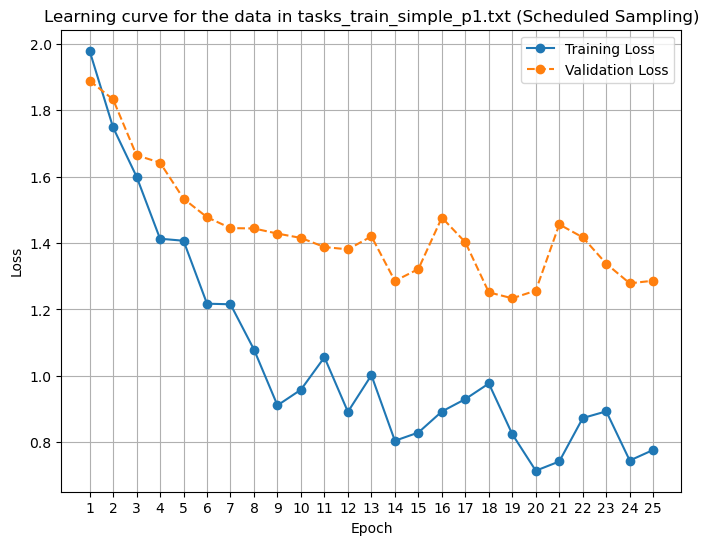

100%|██████████| 25/25 [15:19<00:00, 36.76s/it]


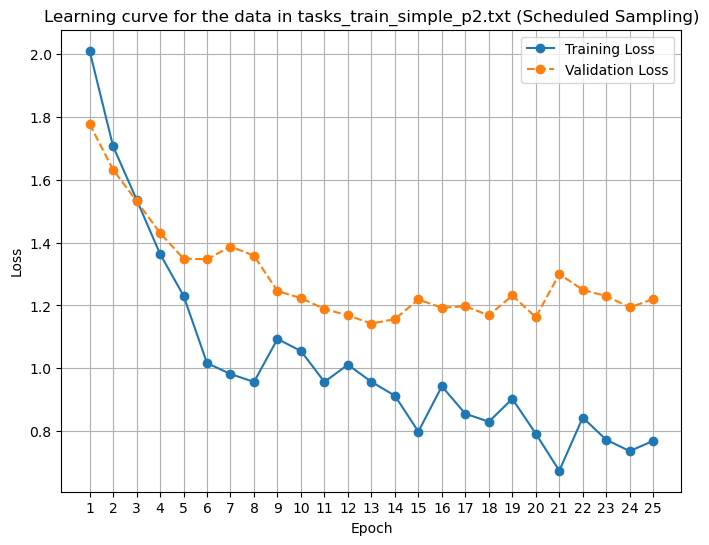

100%|██████████| 25/25 [21:19<00:00, 51.16s/it]


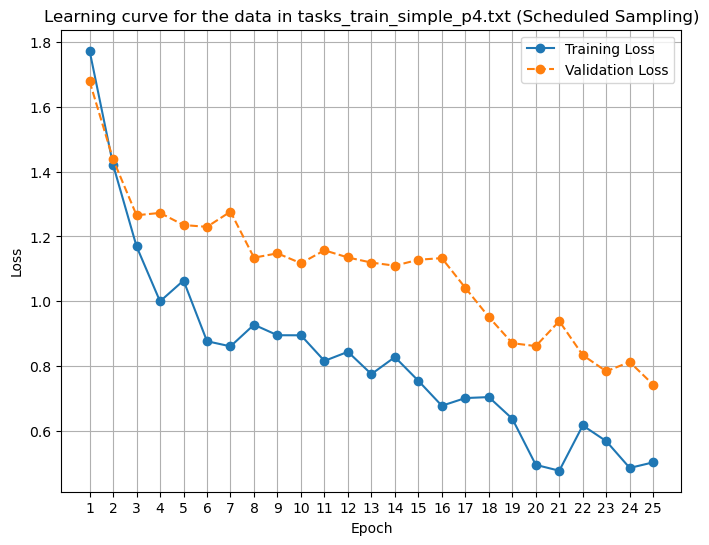

100%|██████████| 25/25 [33:29<00:00, 80.38s/it]


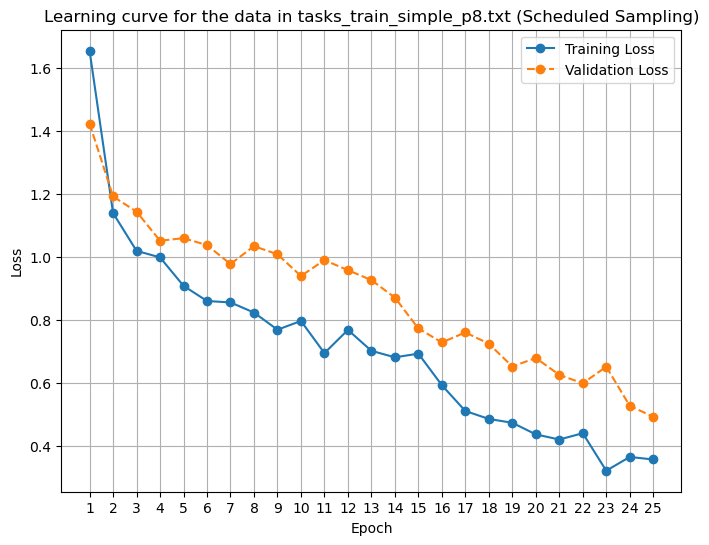

 64%|██████▍   | 16/25 [7:43:18<4:20:36, 1737.41s/it] 


KeyboardInterrupt: 

In [27]:
for train_path, _ in paths:
    train_loss_over_epochs(train_path, scheduled_sampling=True)

100%|██████████| 25/25 [03:08<00:00,  7.54s/it]


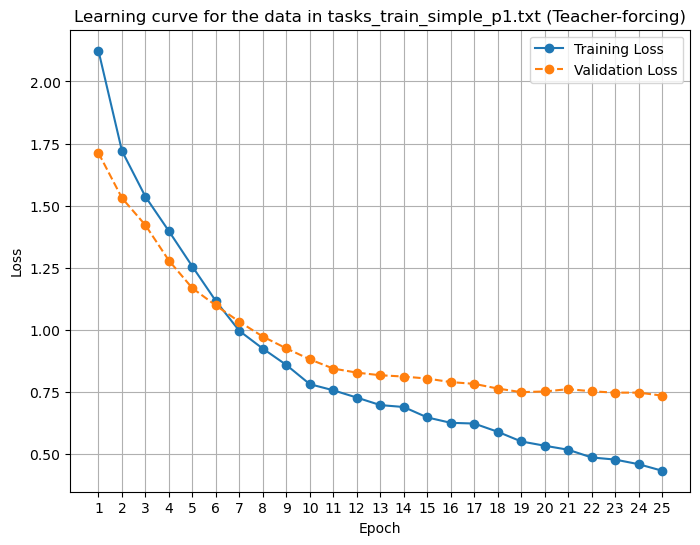

100%|██████████| 25/25 [04:02<00:00,  9.69s/it]


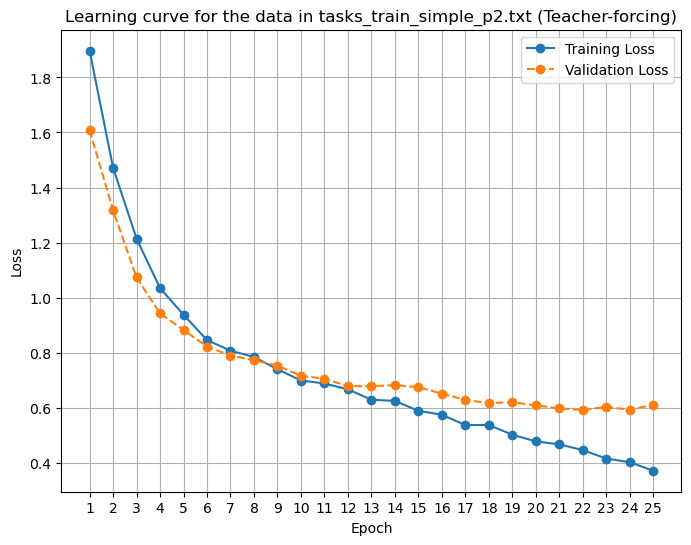

100%|██████████| 25/25 [04:15<00:00, 10.23s/it]


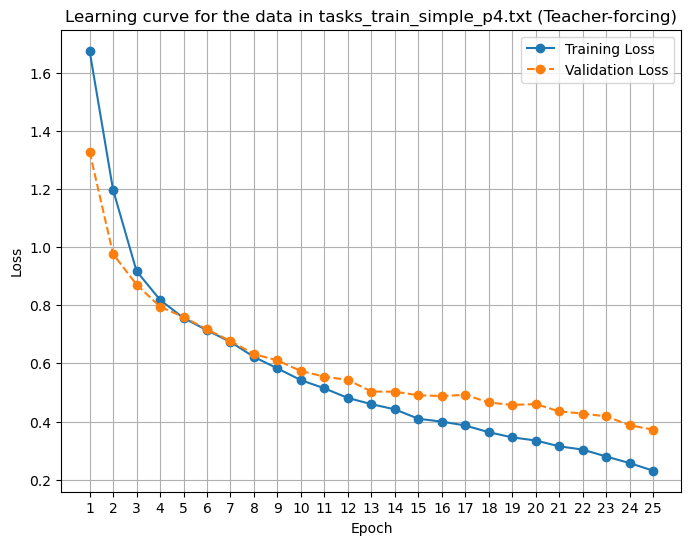

100%|██████████| 25/25 [08:25<00:00, 20.23s/it]


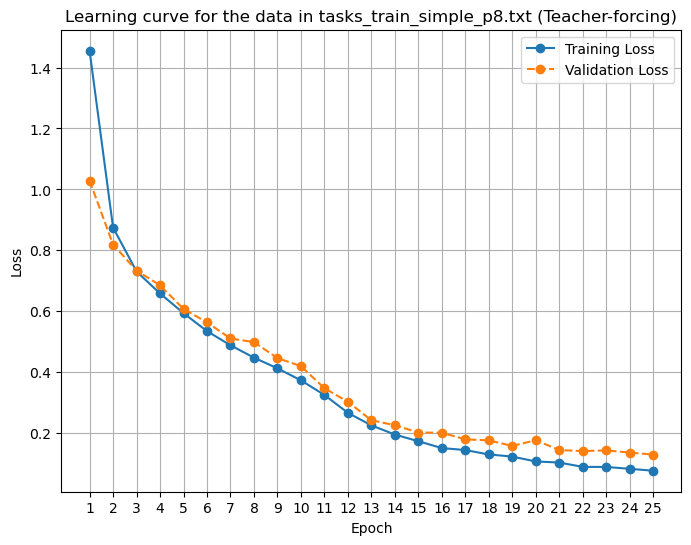

100%|██████████| 25/25 [14:08<00:00, 33.96s/it]


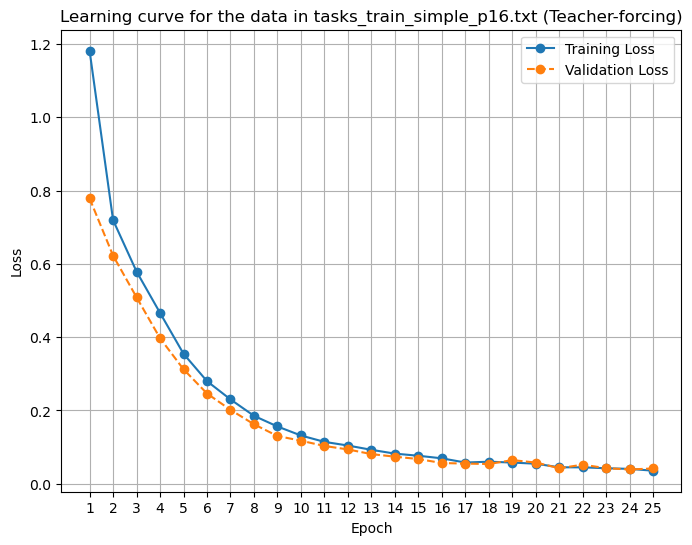

100%|██████████| 25/25 [12:11<00:00, 29.25s/it]


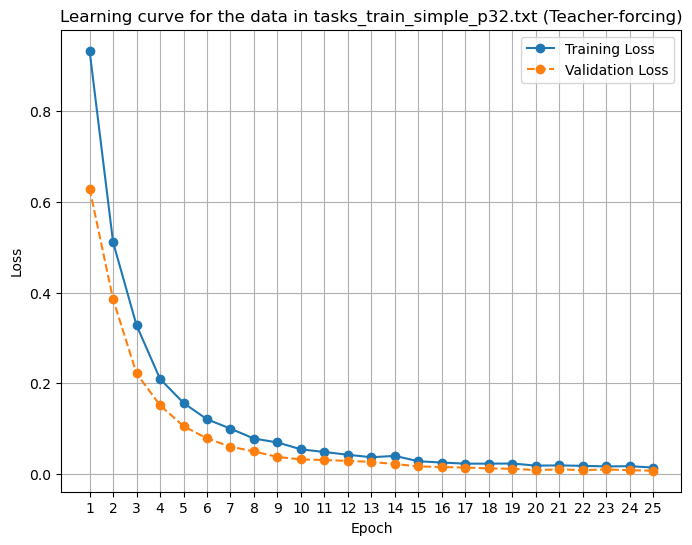

100%|██████████| 25/25 [17:07<00:00, 41.08s/it]


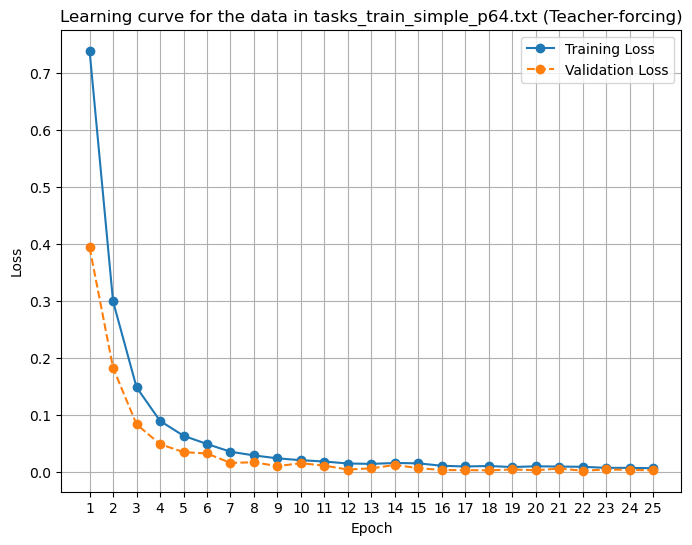

100%|██████████| 25/25 [22:15<00:00, 53.40s/it]


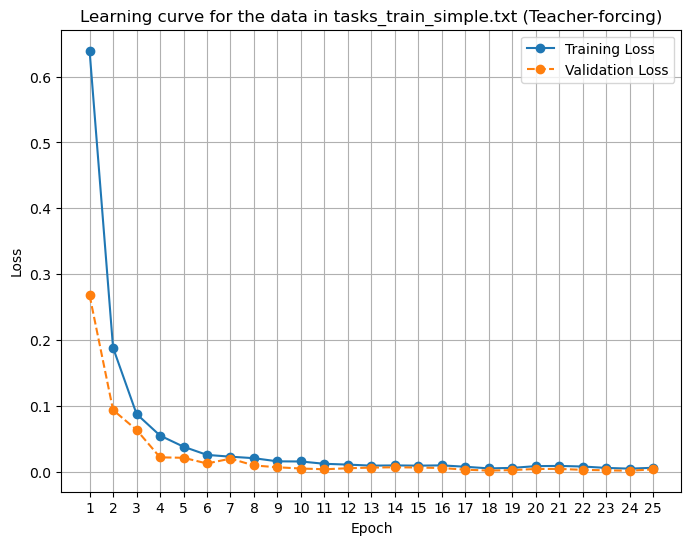

In [10]:
for train_path, _ in paths:
    train_loss_over_epochs(train_path, scheduled_sampling=False)

In [12]:
def plot_accuracy_over_splits(nr_epochs_per_split, scheduled_sampling=True):
    N = len(nr_epochs_per_split)
    Y = []
    for i in range(N):
        train_path, test_path = paths[i]

        dataset_train = SCANDataset(
            file_path=train_path,
            src_vocab=src_vocab,
            tgt_vocab=tgt_vocab,
            max_len=MAX_LEN,
        )

        dataset_test = SCANDataset(
            file_path=test_path,
            src_vocab=src_vocab,
            tgt_vocab=tgt_vocab,
            max_len=MAX_LEN,
        )

        dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
        dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

        # define model
        model = Transformer(
            src_vocab_size=len(src_vocab),
            tgt_vocab_size=len(tgt_vocab),
            src_pad_idx=src_vocab['<PAD>'],
            tgt_pad_idx=tgt_vocab['<PAD>'],
            emb_dim=EMB_DIM,
            num_layers=N_LAYERS,
            num_heads=N_HEADS,
            forward_dim=FORWARD_DIM,
            dropout=DROPOUT,
            max_len=MAX_LEN + 1,
        ).to(device)

        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
        criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<PAD>'])

        train_loop(model, optimizer, criterion, dataloader_train, nr_epochs_per_split[i], scheduled_sampling)

        accuracy = eval_loop(model, dataloader_test, scheduled_sampling)['token_accuracy']

        Y.append(accuracy * 100)

    X = ['1%', '2%', '4%', '8%', '16%', '32%', '64%', '100%']

    plt.figure(figsize=(8, 5))  # Set figure size
    plt.bar(X, Y, color='royalblue')  # Create a bar plot with blue bars
    plt.xlabel('Commands Used', fontsize=12)  # Label for x-axis
    plt.ylabel('Accuracy (%)', fontsize=12)  # Label for y-axis
    plt.ylim(0, 110)  # Set y-axis range to go slightly above 100 for better visualization
    plt.title(f"Accuracy vs Commands Used ({'Scheduled Sampling' if scheduled_sampling else 'Teacher-forcing'})",
               fontsize=14)  # Title for the chart
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines
    plt.tight_layout()  # Adjust layout for better spacing
    plt.savefig(f"plots//experiment1 token-level accuracy{'Scheduled Sampling' if scheduled_sampling else 'Teacher-forcing'}).png")
    plt.show()

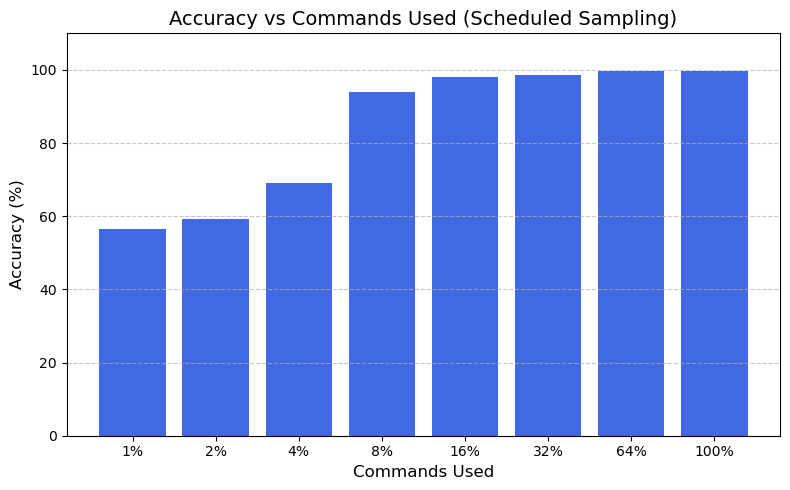

In [36]:
nr_epochs_per_split = [15, 18, 20, 21, 20, 10, 10, 9]
plot_accuracy_over_splits(nr_epochs_per_split, scheduled_sampling=True)

  8%|▊         | 1/12 [00:02<00:24,  2.19s/it]

Epoch 1, Loss: 1.9559


 17%|█▋        | 2/12 [00:04<00:22,  2.24s/it]

Epoch 2, Loss: 1.5473


 25%|██▌       | 3/12 [00:06<00:20,  2.23s/it]

Epoch 3, Loss: 1.3486


 33%|███▎      | 4/12 [00:08<00:17,  2.22s/it]

Epoch 4, Loss: 1.2040


 42%|████▏     | 5/12 [00:11<00:15,  2.24s/it]

Epoch 5, Loss: 1.0292


 50%|█████     | 6/12 [00:13<00:13,  2.25s/it]

Epoch 6, Loss: 0.9394


 58%|█████▊    | 7/12 [00:15<00:11,  2.27s/it]

Epoch 7, Loss: 0.8897


 67%|██████▋   | 8/12 [00:18<00:09,  2.27s/it]

Epoch 8, Loss: 0.8174


 75%|███████▌  | 9/12 [00:20<00:06,  2.27s/it]

Epoch 9, Loss: 0.8343


 83%|████████▎ | 10/12 [00:22<00:04,  2.28s/it]

Epoch 10, Loss: 0.7461


 92%|█████████▏| 11/12 [00:24<00:02,  2.27s/it]

Epoch 11, Loss: 0.7110


100%|██████████| 12/12 [00:27<00:00,  2.26s/it]

Epoch 12, Loss: 0.6927


Token-level accuracy:  0.7292578403016491 Sequence-level accuracy:  0.0


  8%|▊         | 1/13 [00:03<00:44,  3.74s/it]

Epoch 1, Loss: 1.8912


 15%|█▌        | 2/13 [00:07<00:40,  3.69s/it]

Epoch 2, Loss: 1.4012


 23%|██▎       | 3/13 [00:11<00:36,  3.66s/it]

Epoch 3, Loss: 1.1605


 31%|███       | 4/13 [00:14<00:33,  3.71s/it]

Epoch 4, Loss: 0.9602


 38%|███▊      | 5/13 [00:19<00:33,  4.16s/it]

Epoch 5, Loss: 0.8520


 46%|████▌     | 6/13 [00:24<00:31,  4.43s/it]

Epoch 6, Loss: 0.7839


 54%|█████▍    | 7/13 [00:29<00:27,  4.59s/it]

Epoch 7, Loss: 0.7411


 62%|██████▏   | 8/13 [00:34<00:23,  4.70s/it]

Epoch 8, Loss: 0.7102


 69%|██████▉   | 9/13 [00:39<00:19,  4.82s/it]

Epoch 9, Loss: 0.6876


 77%|███████▋  | 10/13 [00:44<00:14,  4.85s/it]

Epoch 10, Loss: 0.6440


 85%|████████▍ | 11/13 [00:49<00:09,  4.87s/it]

Epoch 11, Loss: 0.6242


 92%|█████████▏| 12/13 [00:54<00:04,  4.85s/it]

Epoch 12, Loss: 0.5885


100%|██████████| 13/13 [00:59<00:00,  4.55s/it]

Epoch 13, Loss: 0.5556


Token-level accuracy:  0.775675039861986 Sequence-level accuracy:  0.0


  7%|▋         | 1/14 [00:05<01:17,  5.93s/it]

Epoch 1, Loss: 1.6077


 14%|█▍        | 2/14 [00:12<01:12,  6.06s/it]

Epoch 2, Loss: 1.0100


 21%|██▏       | 3/14 [00:18<01:07,  6.10s/it]

Epoch 3, Loss: 0.8744


 29%|██▊       | 4/14 [00:24<01:01,  6.13s/it]

Epoch 4, Loss: 0.7925


 36%|███▌      | 5/14 [00:30<00:55,  6.15s/it]

Epoch 5, Loss: 0.7296


 43%|████▎     | 6/14 [00:36<00:49,  6.14s/it]

Epoch 6, Loss: 0.6543


 50%|█████     | 7/14 [00:42<00:43,  6.15s/it]

Epoch 7, Loss: 0.6117


 57%|█████▋    | 8/14 [00:49<00:36,  6.16s/it]

Epoch 8, Loss: 0.5562


 64%|██████▍   | 9/14 [00:55<00:30,  6.18s/it]

Epoch 9, Loss: 0.5235


 71%|███████▏  | 10/14 [01:01<00:24,  6.17s/it]

Epoch 10, Loss: 0.4933


 79%|███████▊  | 11/14 [01:07<00:18,  6.20s/it]

Epoch 11, Loss: 0.4591


 86%|████████▌ | 12/14 [01:14<00:12,  6.31s/it]

Epoch 12, Loss: 0.4457


 93%|█████████▎| 13/14 [01:20<00:06,  6.30s/it]

Epoch 13, Loss: 0.4009


100%|██████████| 14/14 [01:26<00:00,  6.20s/it]

Epoch 14, Loss: 0.3845


Token-level accuracy:  0.8662882978211727 Sequence-level accuracy:  0.004832121151738567


  8%|▊         | 1/13 [00:08<01:47,  8.93s/it]

Epoch 1, Loss: 1.3400


 15%|█▌        | 2/13 [00:17<01:37,  8.88s/it]

Epoch 2, Loss: 0.8100


 23%|██▎       | 3/13 [00:26<01:28,  8.83s/it]

Epoch 3, Loss: 0.6966


 31%|███       | 4/13 [00:35<01:19,  8.83s/it]

Epoch 4, Loss: 0.6077


 38%|███▊      | 5/13 [00:44<01:10,  8.84s/it]

Epoch 5, Loss: 0.5364


 46%|████▌     | 6/13 [00:53<01:02,  8.86s/it]

Epoch 6, Loss: 0.4760


 54%|█████▍    | 7/13 [01:02<00:53,  8.95s/it]

Epoch 7, Loss: 0.4359


 62%|██████▏   | 8/13 [01:11<00:44,  8.95s/it]

Epoch 8, Loss: 0.3618


 69%|██████▉   | 9/13 [01:20<00:35,  8.96s/it]

Epoch 9, Loss: 0.2893


 77%|███████▋  | 10/13 [01:29<00:26,  8.93s/it]

Epoch 10, Loss: 0.2406


 85%|████████▍ | 11/13 [01:38<00:17,  8.96s/it]

Epoch 11, Loss: 0.2031


 92%|█████████▏| 12/13 [01:47<00:08,  8.97s/it]

Epoch 12, Loss: 0.1803


100%|██████████| 13/13 [01:55<00:00,  8.92s/it]

Epoch 13, Loss: 0.1667


Token-level accuracy:  0.9432863274064991 Sequence-level accuracy:  0.027653602245555672


  6%|▋         | 1/16 [00:13<03:24, 13.65s/it]

Epoch 1, Loss: 1.0723


 12%|█▎        | 2/16 [00:29<03:25, 14.66s/it]

Epoch 2, Loss: 0.6665


 19%|█▉        | 3/16 [01:04<05:14, 24.21s/it]

Epoch 3, Loss: 0.5245


 25%|██▌       | 4/16 [01:23<04:27, 22.26s/it]

Epoch 4, Loss: 0.4119


 31%|███▏      | 5/16 [01:39<03:38, 19.89s/it]

Epoch 5, Loss: 0.2706


 38%|███▊      | 6/16 [01:55<03:06, 18.64s/it]

Epoch 6, Loss: 0.1799


 44%|████▍     | 7/16 [02:14<02:47, 18.63s/it]

Epoch 7, Loss: 0.1372


 50%|█████     | 8/16 [02:30<02:23, 17.97s/it]

Epoch 8, Loss: 0.1140


 56%|█████▋    | 9/16 [02:48<02:03, 17.70s/it]

Epoch 9, Loss: 0.0967


 62%|██████▎   | 10/16 [03:03<01:41, 17.00s/it]

Epoch 10, Loss: 0.0800


 69%|██████▉   | 11/16 [03:18<01:22, 16.45s/it]

Epoch 11, Loss: 0.0679


 75%|███████▌  | 12/16 [03:31<01:01, 15.43s/it]

Epoch 12, Loss: 0.0634


 81%|████████▏ | 13/16 [03:44<00:44, 14.75s/it]

Epoch 13, Loss: 0.0590


 88%|████████▊ | 14/16 [03:58<00:28, 14.36s/it]

Epoch 14, Loss: 0.0476


 94%|█████████▍| 15/16 [04:11<00:14, 14.01s/it]

Epoch 15, Loss: 0.0452


100%|██████████| 16/16 [04:25<00:00, 16.58s/it]

Epoch 16, Loss: 0.0428


Token-level accuracy:  0.9916624557857504 Sequence-level accuracy:  0.02220324508966695


 10%|█         | 1/10 [01:50<16:33, 110.39s/it]

Epoch 1, Loss: 0.9026


 20%|██        | 2/10 [02:43<10:13, 76.65s/it] 

Epoch 2, Loss: 0.4901


 30%|███       | 3/10 [02:53<05:25, 46.43s/it]

Epoch 3, Loss: 0.2625


 40%|████      | 4/10 [03:04<03:13, 32.28s/it]

Epoch 4, Loss: 0.1291


 50%|█████     | 5/10 [03:15<02:02, 24.59s/it]

Epoch 5, Loss: 0.0853


 60%|██████    | 6/10 [03:26<01:20, 20.04s/it]

Epoch 6, Loss: 0.0671


 70%|███████   | 7/10 [03:45<00:58, 19.53s/it]

Epoch 7, Loss: 0.0519


 80%|████████  | 8/10 [05:03<01:16, 38.28s/it]

Epoch 8, Loss: 0.0427


 90%|█████████ | 9/10 [06:23<00:51, 51.20s/it]

Epoch 9, Loss: 0.0356


100%|██████████| 10/10 [08:12<00:00, 49.26s/it]

Epoch 10, Loss: 0.0302


Token-level accuracy:  0.9959942859667467 Sequence-level accuracy:  0.16393557915465223


 12%|█▎        | 1/8 [03:31<24:41, 211.64s/it]

Epoch 1, Loss: 0.6880


 25%|██▌       | 2/8 [07:10<21:35, 215.97s/it]

Epoch 2, Loss: 0.2262


 38%|███▊      | 3/8 [10:55<18:21, 220.20s/it]

Epoch 3, Loss: 0.1070


 50%|█████     | 4/8 [14:29<14:29, 217.43s/it]

Epoch 4, Loss: 0.0670


 62%|██████▎   | 5/8 [17:57<10:42, 214.03s/it]

Epoch 5, Loss: 0.0436


 75%|███████▌  | 6/8 [21:35<07:10, 215.37s/it]

Epoch 6, Loss: 0.0339


 88%|████████▊ | 7/8 [24:45<03:27, 207.25s/it]

Epoch 7, Loss: 0.0260


100%|██████████| 8/8 [27:16<00:00, 204.51s/it]

Epoch 8, Loss: 0.0191


Token-level accuracy:  0.9987386819226092 Sequence-level accuracy:  0.023113708820403825


 12%|█▎        | 1/8 [03:14<22:41, 194.50s/it]

Epoch 1, Loss: 0.6033


 25%|██▌       | 2/8 [06:37<19:56, 199.38s/it]

Epoch 2, Loss: 0.1576


 38%|███▊      | 3/8 [09:17<15:08, 181.70s/it]

Epoch 3, Loss: 0.0706


 50%|█████     | 4/8 [12:32<12:27, 186.84s/it]

Epoch 4, Loss: 0.0413


 62%|██████▎   | 5/8 [15:59<09:41, 193.88s/it]

Epoch 5, Loss: 0.0283


 75%|███████▌  | 6/8 [18:33<06:00, 180.49s/it]

Epoch 6, Loss: 0.0216


 88%|████████▊ | 7/8 [20:54<02:47, 167.47s/it]

Epoch 7, Loss: 0.0161


100%|██████████| 8/8 [24:20<00:00, 182.52s/it]

Epoch 8, Loss: 0.0138


Token-level accuracy:  0.9991896272285251 Sequence-level accuracy:  0.03538976566236251


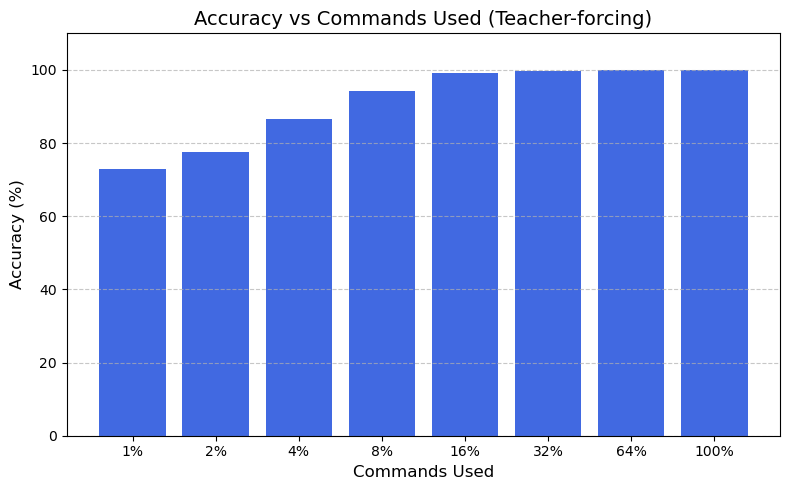

In [17]:
nr_epochs_per_split = [12, 13, 14, 13, 16, 10, 8, 8]
plot_accuracy_over_splits(nr_epochs_per_split, scheduled_sampling=False)